<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [ ]:
!pip install catboost
!pip install optuna

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import scipy.sparse
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, \
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss, auc, roc_curve
from catboost import CatBoostClassifier
import optuna

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 209 kB 62.5 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 147 kB 42.4 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 112 kB 61.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=8cda3db216578e4e79a31c2d7e182a1a94b771fd11c694f1228cb6963a12686a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

Подключим гугл-диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/dls train.csv')

In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Выведем 5 строк

In [ ]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Выведем полную информацию о датафрейме

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Видим, что пропущенные значение отсутствуют

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

Определим функцию для подписи процентов

In [ ]:
def plot_text(ax):
    """
    Добавление подписи процентов на график barplot
    :param ax: ось
    :return: None
    """
    for p in ax.patches:
        percentage = '{:.1f}'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=10)

Признак TotalSpent имеет тип object. Сделаем небольшую предобработку и посмотрим, все ли значения можно привести к числовому типу (если да, то будет
возвращён пустой список)

In [ ]:
nans = pd.to_numeric(data['TotalSpent'], errors="coerce").isna().reset_index()
true_nans = nans[nans['TotalSpent']==True]
true_nans

,index,TotalSpent
1048,1048,True
1707,1707,True
2543,2543,True
3078,3078,True
3697,3697,True
4002,4002,True
4326,4326,True
4551,4551,True
4598,4598,True


Видим, что нельзя. Посмотрим, что лежит в этих строках

In [ ]:
for x in true_nans['index']:
    print("\'" + data['TotalSpent'][x] + "\'")

' '
' '
' '
' '
' '
' '
' '
' '
' '


Видим, что это, по сути, пробельные символы. Для простоты просто удалим соответствующие строки

In [ ]:
data = data.drop(true_nans['index'])
data.shape

(5273, 20)

Теперь приведём признак TotalSpent к типу float

In [ ]:
data['TotalSpent'] = data['TotalSpent'].astype(float)

Построим гистограммы для числовых признаков

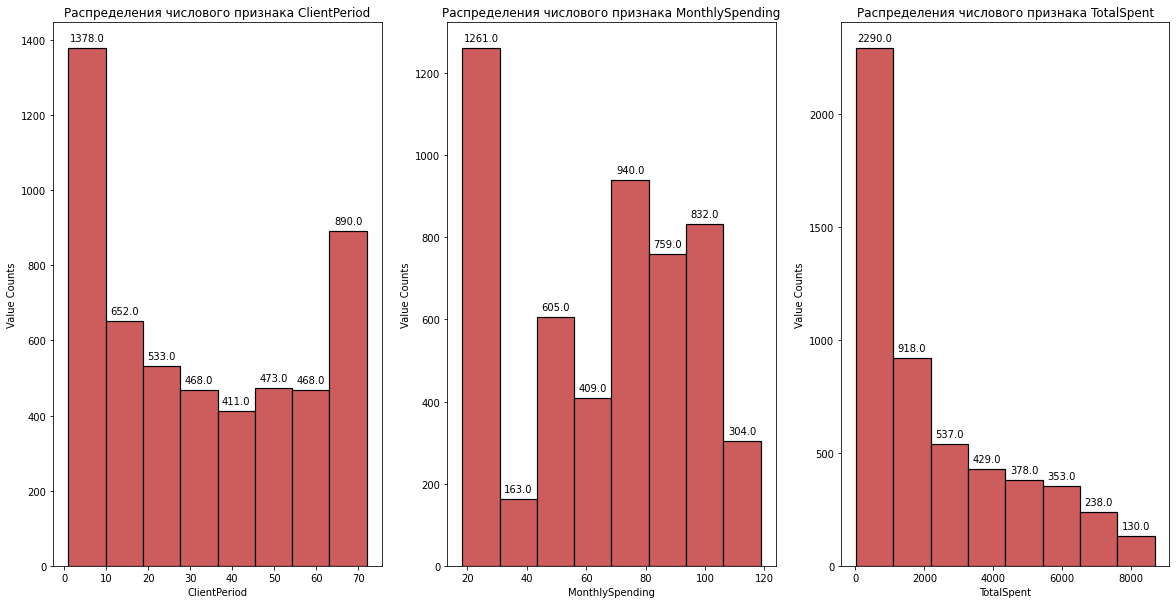

In [ ]:
# Зададим параметры для подачи в subplots, предполагая, что хотим разместить все графики на одной строке
num_of_cols = 3
num_of_rows = 1

_, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(20, 10))

for x, i in zip(num_cols, range(3)):
    axs[i].hist(data[x], bins=8, color='indianred', edgecolor='black',
                linewidth=1.2)
    axs[i].set_title('Распределения числового признака ' + x)
    axs[i].set_xlabel(x)
    axs[i].set_ylabel('Value Counts')
    plot_text(axs[i]);

Построим столбчатые диаграммы для категориальных признаков

In [ ]:
value_counts = data['Sex'].value_counts()
value_counts.reset_index()

,index,Sex
0,Male,2651
1,Female,2622


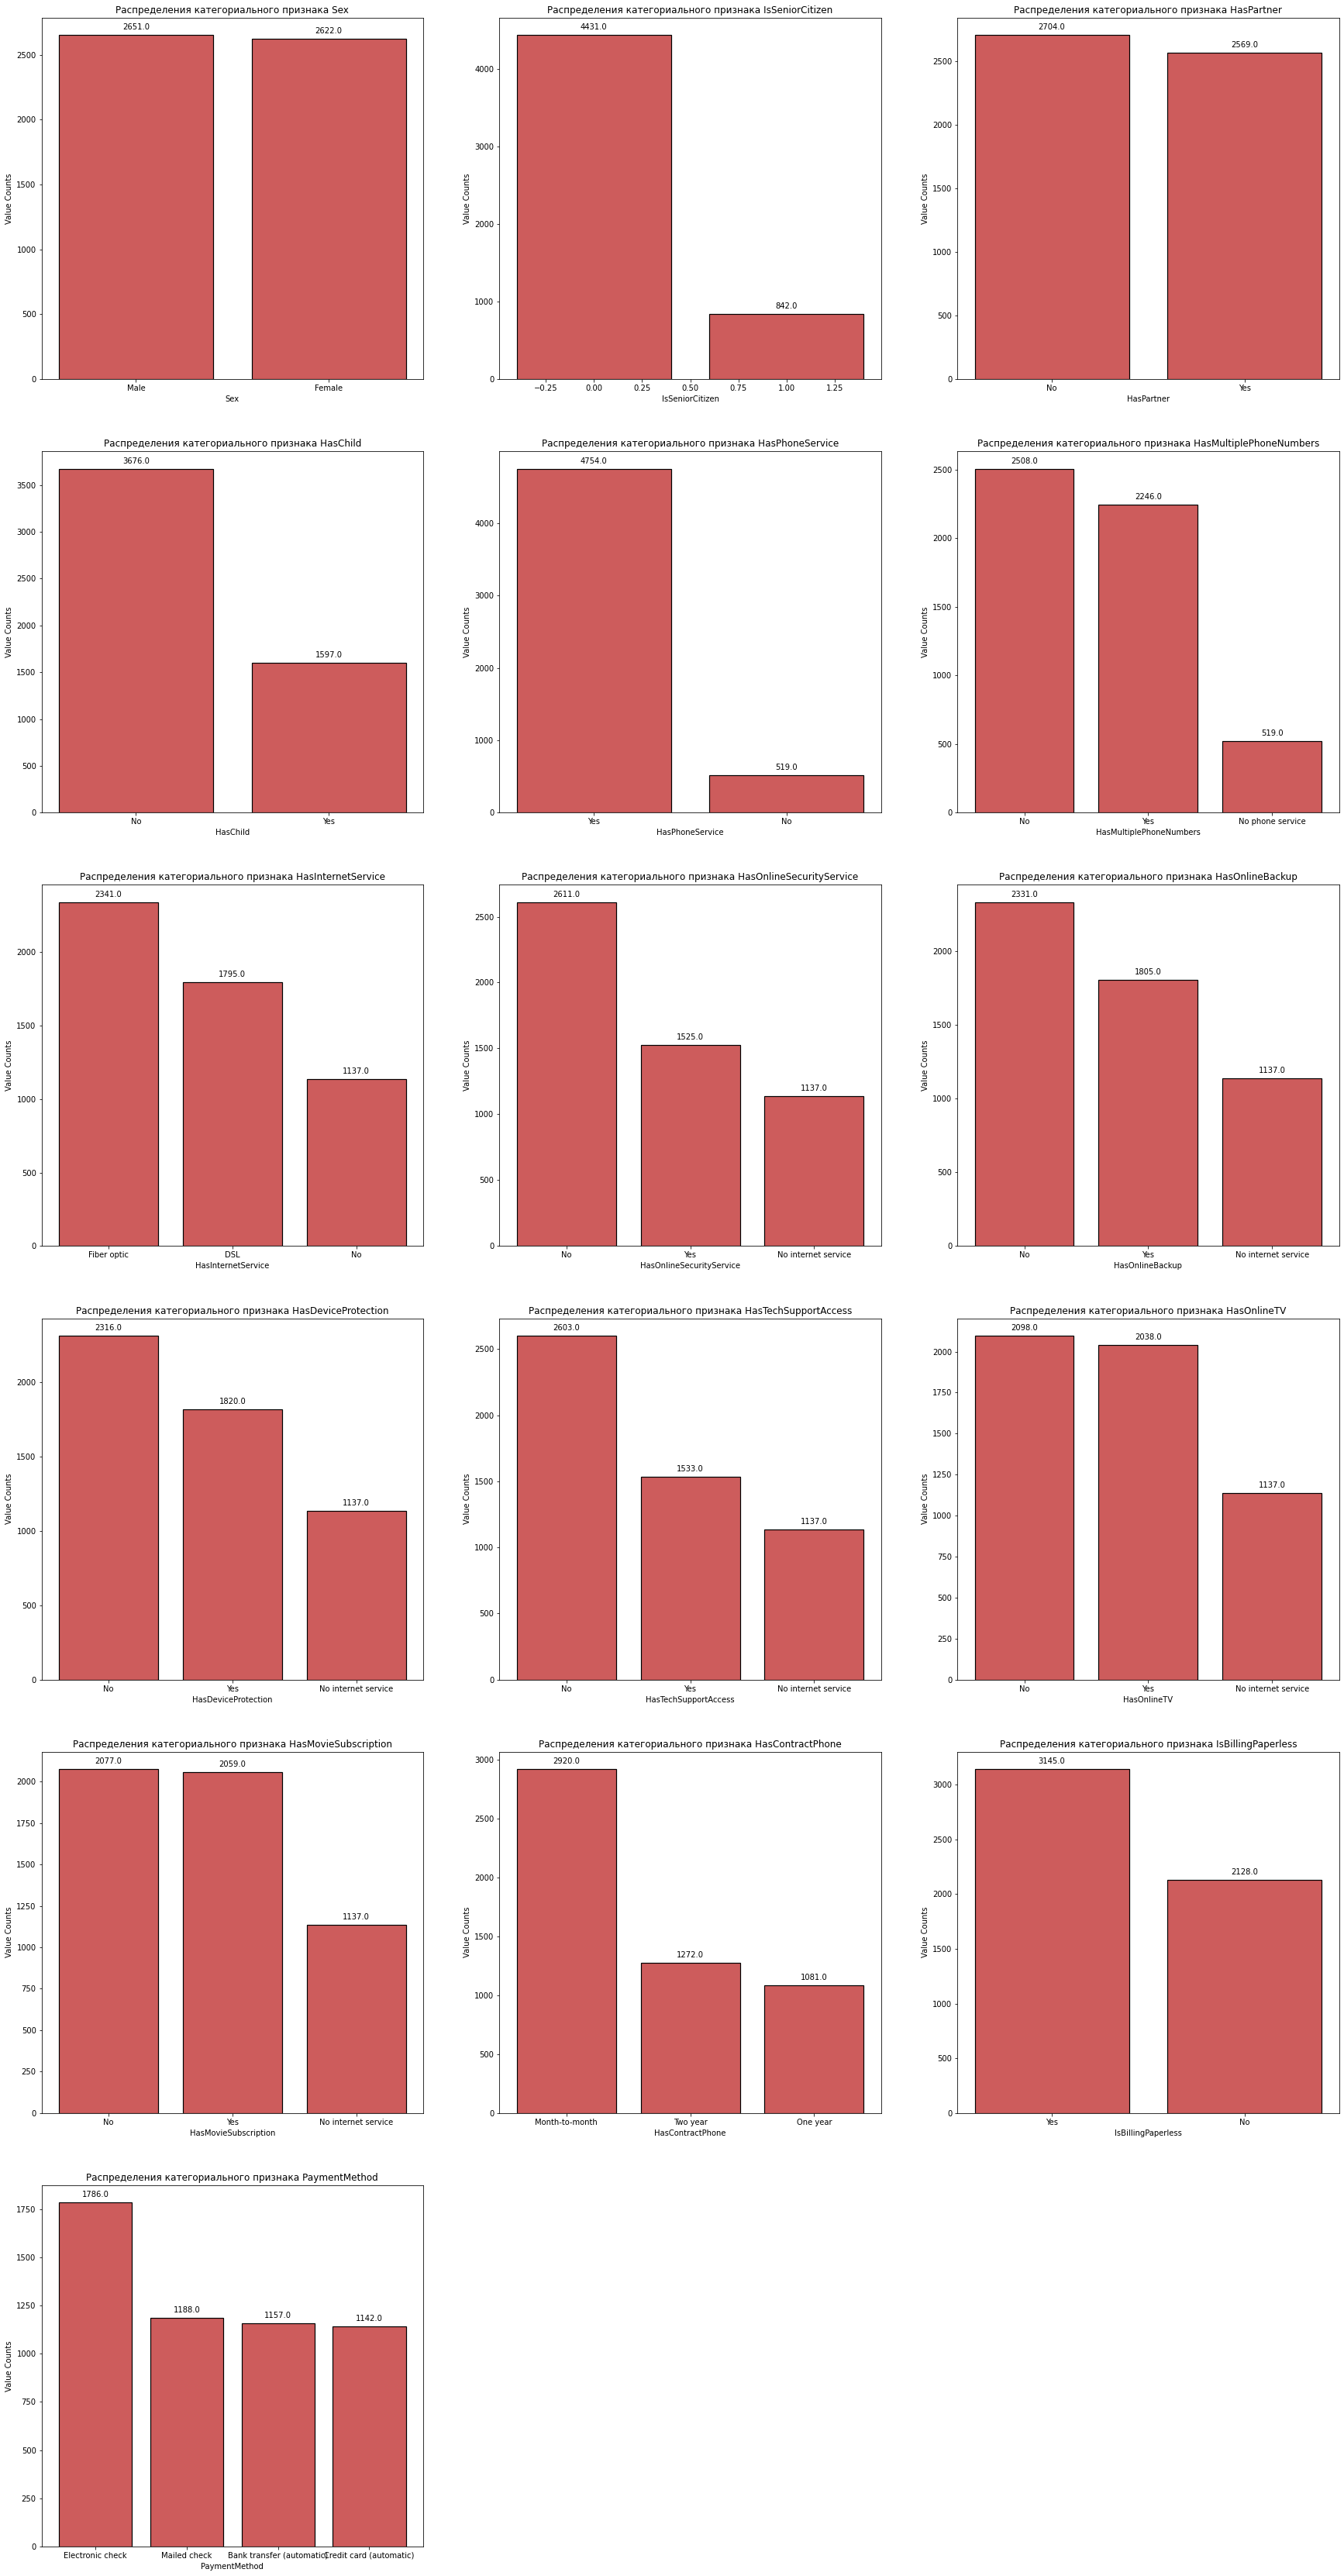

In [ ]:
# Зададим параметры для подачи в subplots, предполагая, что хотим размещать по 3 графика на одной строке
num_of_cols = 3
num_of_rows = 6

fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(30, 60))
plt.xticks(rotation=70)
fig.delaxes(axs[5][1])
fig.delaxes(axs[5][2])

for i in range(num_of_rows):
    for x, j in zip(cat_cols[i * num_of_cols:
                             i * num_of_cols + num_of_cols], range(num_of_cols)):
        # Датафрейм частот
        value_counts = data[x].value_counts().reset_index()
        axs[i][j].bar(value_counts['index'],
                      value_counts[x],
                      color='indianred',
                      edgecolor='black',
                      linewidth=1.2)
        axs[i][j].set_title('Распределения категориального признака ' + x)
        axs[i][j].set_xlabel(x)
        axs[i][j].set_ylabel('Value Counts')
        plot_text(axs[i][j]);

Построим график распределения целевой переменной Churn, чтобы оценить дисбаланс классов. Используем для этого библиотеку seaborn. Скорее всего, в будущем нам часто предстоит смотреть распределение target-признака, поэтому для удобства реализуем метод, который внутри себя будет производить все нужные действия

In [ ]:
def barplot(df: pd.DataFrame,
            col: str,
            title: str) -> None:
    """
    Построение графика распределения признака в виде столбчатой диаграммы
    :param df: датасет
    :param col: столбец, для которого которого хотим смотреть распределение
    :param title: заголовок
    :return: None
    """
    rcParams['figure.figsize'] = 10, 8
    sns.color_palette("YlOrBr", as_cmap=True)

    # Датафрейм частот значений
    norm_target = pd.DataFrame(df[col].value_counts(normalize=True).mul(100) \
                               .rename('percent')).reset_index()

    ax = sns.barplot(x='index', y='percent', data=norm_target, palette="flare")
    plt.title(title)
    plot_text(ax)

Отрисуем график

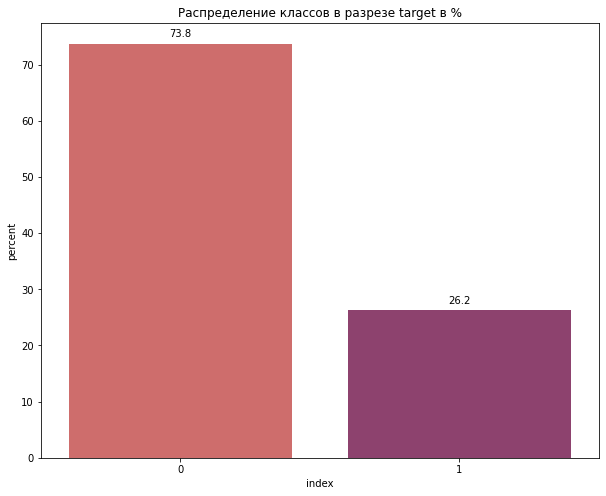

In [ ]:
barplot(
    df=data,
    col='Churn',
    title='Распределение классов в разрезе target в %')

Видим, что есть дисбаланс

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

Судя по графикам, выбросов нет. Строки с пустыми значениями мы уже убрали, остановимся пока на этом

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

Отнормируем числовые признаки

In [ ]:
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[num_cols] = scaler.fit_transform(data[num_cols])
data_scaled[num_cols].head()

,ClientPeriod,MonthlySpending,TotalSpent
0,0.919099,-1.506436,-0.557582
1,1.612060,-1.295997,-0.184763
2,-1.282072,0.362658,-0.976504
3,-0.018437,0.475334,0.122800
4,1.122911,1.666716,1.968909


Закодируем категориальные признаки

In [ ]:
ohe = OneHotEncoder()
array_hot_encoded = ohe.fit_transform(data_scaled[cat_cols])
data_hot_encoded = pd.DataFrame.sparse.from_spmatrix(array_hot_encoded)
data_hot_encoded
data_other_cols = data_scaled.drop(columns=cat_cols)

data_scaled_bin = pd.concat([data_hot_encoded, data_other_cols], axis=1).dropna()
data_scaled_bin.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,ClientPeriod,MonthlySpending,TotalSpent,Churn
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.919099,-1.506436,-0.557582,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.612060,-1.295997,-0.184763,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,-1.282072,0.362658,-0.976504,1.0
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,-0.018437,0.475334,0.122800,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.122911,1.666716,1.968909,0.0


Разделим данные на обучающую и тестовую выборку

In [ ]:
feature_cols_scaled_bin = data_scaled_bin.drop(columns=['Churn'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_cols_scaled_bin,
                                                    data_scaled_bin['Churn'],
                                                    test_size=0.16,
                                                    random_state=10)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
lr_cv = LogisticRegressionCV(scoring='roc_auc', refit=True)
lr_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

Определим метод, который позволит выводить все метрики классификации

In [ ]:
def get_metrics(y_test, y_pred, name):
    df_metrics = pd.DataFrame()
  
    df_metrics['model'] = [name]
    
    df_metrics['Accuracy'] = [accuracy_score(y_test, y_pred)]
    df_metrics['ROC_AUC'] = [roc_auc_score(y_test, y_pred)]
    df_metrics['Precision'] = [precision_score(y_test, y_pred)]
    df_metrics['Recall'] = [recall_score(y_test, y_pred)]
    df_metrics['f1'] = [f1_score(y_test, y_pred)]
    df_metrics['Logloss'] = [log_loss(y_test, y_pred)]
    
    return df_metrics

In [ ]:
predict = lr_cv.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [ ]:
get_metrics(y_test, predict, name='lr_cv')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,lr_cv,0.781732,0.657912,0.581081,0.413462,0.483146,7.538772


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Таким образом roc auc на тестовой выборке составил 0.65. Выведем параметры модели

In [ ]:
lr_cv.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Разобьём исходные данные на train и test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols],
                                                    data['Churn'],
                                                    test_size=0.16,
                                                    random_state=10)

Выделим из обучающей выборки валидационное множество, на котором будем проверять ответ после построения каждого дерева. Это нужно, чтобы контролировать переобучение и останавливать построение композиции, когда метрика качества перестаёт улучшаться

In [ ]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=10)
eval_set = [(X_val, y_val)]

Обучим базовую модель Catboost

In [ ]:
clf = CatBoostClassifier(random_state=10,\
                         scale_pos_weight=0.738,
                         cat_features = cat_cols)

In [ ]:
clf.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        early_stopping_rounds=100,
        verbose=2)

Learning rate set to 0.043836
0:	learn: 0.6631792	test: 0.6615998	best: 0.6615998 (0)	total: 12.1ms	remaining: 12.1s
2:	learn: 0.6129319	test: 0.6083503	best: 0.6083503 (2)	total: 39.3ms	remaining: 13s
4:	learn: 0.5717758	test: 0.5655051	best: 0.5655051 (4)	total: 66.6ms	remaining: 13.3s
6:	learn: 0.5375365	test: 0.5286682	best: 0.5286682 (6)	total: 93.5ms	remaining: 13.3s
8:	learn: 0.5068879	test: 0.4962359	best: 0.4962359 (8)	total: 125ms	remaining: 13.8s
10:	learn: 0.4835078	test: 0.4708800	best: 0.4708800 (10)	total: 149ms	remaining: 13.4s
12:	learn: 0.4629272	test: 0.4486077	best: 0.4486077 (12)	total: 174ms	remaining: 13.2s
14:	learn: 0.4484041	test: 0.4323007	best: 0.4323007 (14)	total: 195ms	remaining: 12.8s
16:	learn: 0.4356340	test: 0.4178254	best: 0.4178254 (16)	total: 222ms	remaining: 12.8s
18:	learn: 0.4261332	test: 0.4066367	best: 0.4066367 (18)	total: 247ms	remaining: 12.7s
20:	learn: 0.4182553	test: 0.3977170	best: 0.3977170 (20)	total: 286ms	remaining: 13.3s
22:	learn:

Получим предсказания и посмотрим на метрики

In [ ]:
y_pred = clf.predict(X_test)
get_metrics(y_test, y_pred, name='Catboost')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Catboost,0.805687,0.682153,0.704545,0.426606,0.531429,6.711363


Таким образом, roc_auc на тестовой выборке составил 0.68, что немного лучше относительно логистической регрессии. Попробуем подобрать learning_rate и n_estimators при помощи библиотеки optuna

In [ ]:
def objective_lgb(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 10000),
        "learning_rate": trial.suggest_float("Learning_rate", 0.001, 0.3),
        "cat_features":
        trial.suggest_categorical("cat_features", [cat_cols]),
        "loss_function":
        trial.suggest_categorical("loss_function", ["Logloss"]),
        "use_best_model":
        trial.suggest_categorical("use_best_model", [True]),
        "random_state":
        random_state,
        "scale_pos_weight": 
        trial.suggest_categorical("scale_pos_weight", [0.738])
    }
       
    # Внутри проводим кросс-валидацию, возвращаем средний скор на фолдах
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=random_state)
        eval_set = [(X_val, y_val)]  

        model = CatBoostClassifier(**params)
        model.fit(X_train_,
                  y_train_,
                  eval_set=eval_set,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_predicts)

study_cat = optuna.create_study(direction="maximize", study_name="Catboost")
func = lambda trial: objective_lgb(
    trial, X_train, y_train, N_FOLDS=5, random_state=10, cat_feat=cat_cols)

study_cat.optimize(func, n_trials=20, show_progress_bar=True)

[I 2022-10-28 00:28:30,306] A new study created in memory with name: Catboost


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-10-28 00:29:22,377] Trial 0 finished with value: 0.669807684666307 and parameters: {'n_estimators': 4612, 'Learning_rate': 0.00716288811555379, 'cat_features': ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'], 'loss_function': 'Logloss', 'use_best_model': True, 'scale_pos_weight': 0.738}. Best is trial 0 with value: 0.669807684666307.
[I 2022-10-28 00:29:32,177] Trial 1 finished with value: 0.673846903689282 and parameters: {'n_estimators': 618, 'Learning_rate': 0.13284331779246045, 'cat_features': ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlin

Теперь подберём другие гиперпараметры с подобранным числом деревьев 3401 и learning_rate, равном 0.1

In [ ]:
def objective_lgb(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators":
        trial.suggest_categorical("n_estimators", [3401]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.1]),
        "max_depth":
        trial.suggest_int("max_depth", 3, 12),
        "l2_leaf_reg":
        trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
        "bootstrap_type":
        trial.suggest_categorical("bootstrap_type",
                                  ["Bayesian", "Bernoulli", "MVS", "No"]),
        "border_count":
        trial.suggest_categorical('border_count', [128, 254]),
        "grow_policy":
        trial.suggest_categorical('grow_policy',
                                  ["SymmetricTree", "Depthwise", "Lossguide"]),
        "auto_class_weights":
        trial.suggest_categorical("auto_class_weights",
                                  ["None", "Balanced", "SqrtBalanced"]),
        
        "cat_features":
        trial.suggest_categorical("cat_features", [cat_feat]),
        "loss_function":
        trial.suggest_categorical("loss_function", ["Logloss"]),
        "use_best_model":
        trial.suggest_categorical("use_best_model", [True]),
        "random_state":
        random_state
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample",
                                                  0.1,
                                                  1,
                                                  log=True)
        
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=random_state)
        eval_set = [(X_val, y_val)]  

        model = CatBoostClassifier(**params)
        model.fit(X_train_,
                  y_train_,
                  eval_set=eval_set,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_predicts)

study_cat = optuna.create_study(direction="maximize", study_name="Catboost")
func = lambda trial: objective_lgb(
    trial, X_train, y_train, N_FOLDS=5, random_state=10, cat_feat=cat_cols)

study_cat.optimize(func, n_trials=20, show_progress_bar=True)

[I 2022-10-28 00:45:30,915] A new study created in memory with name: Catboost


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-10-28 00:45:41,274] Trial 0 finished with value: 0.7631641758461328 and parameters: {'n_estimators': 3401, 'learning_rate': 0.1, 'max_depth': 3, 'l2_leaf_reg': 85.86624495921515, 'bootstrap_type': 'Bernoulli', 'border_count': 254, 'grow_policy': 'SymmetricTree', 'auto_class_weights': 'Balanced', 'cat_features': ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'], 'loss_function': 'Logloss', 'use_best_model': True, 'subsample': 0.7427140352971795}. Best is trial 0 with value: 0.7631641758461328.
[I 2022-10-28 00:45:52,838] Trial 1 finished with value: 0.7172525799388676 and parameters: {'n_estimators': 3401, 'learning_rate': 0.1, 'max_depth': 8, 'l2_leaf_reg': 4.221569841922679, 'bootstrap_type': 'No', 'border_count': 254,

Обучимся на лучших параметрах

In [ ]:
model = CatBoostClassifier(**study_cat.best_params)

model.fit(X_train_,
         y_train_,
         eval_set=eval_set,
         early_stopping_rounds=100,
         verbose=0)

Аналогично, посмотрим на результат

In [ ]:
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred, name='Catboost')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Catboost,0.740521,0.756316,0.498551,0.788991,0.611012,8.96224


Видим, что roc_auc довольно сильно улучшился

# Предсказания

In [ ]:
best_model = model

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/dls test.csv')
submission = pd.read_csv('/content/drive/MyDrive/submission.csv')

submission['Churn'] = best_model.predict(X_test)
submission = submission.set_index('Id')
submission.to_csv('./my_submission.csv')

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.